# Linear Variational Auto Encoder
This notebook demonstrates the training of a Linear Variational Autoencoder (VAE) to learn transformations from input climate data to corresponding forced responses, with BCE loss for reconstruction.

In [1]:
# Import necessary libraries
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import random
import warnings


from torch.utils.data import DataLoader

# Add utility paths
sys.path.append(os.path.join(os.getcwd(), 'utils'))

# Import utility functions
from utils.data_loading import *
from utils.data_processing import *
from utils.vae import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# Enable autoreload
%reload_ext autoreload
%autoreload 2

# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define data path
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')
print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Use MPS / Cuda or CPU if none of the options are available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
random.seed(42)

Using device: mps


In [3]:
# Load the data
filename = os.path.join(data_path, 'ssp585_time_series.pkl')
data, nan_mask = preprocess_data(data_path, filename)

Loading data from /Users/lharriso/Documents/GitHub/gm4cs-l/data/ssp585_time_series.pkl
Data loaded successfully.
Filtering data...


100%|██████████| 72/72 [00:00<00:00, 61807.18it/s]


Data filtered. Kept 34 models
Creating NaN mask...


100%|██████████| 34/34 [00:02<00:00, 16.40it/s]


NaN mask created.
Masking out NaN values...


100%|██████████| 34/34 [00:01<00:00, 26.77it/s]


NaN values masked out.
Reshaping data...


100%|██████████| 34/34 [00:04<00:00,  8.02it/s]


Data reshaped.
Adding the forced response to the data...


100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Forced response added.
Removing NaN values from the grid...


100%|██████████| 34/34 [00:01<00:00, 25.04it/s]


NaN values removed.


In [4]:
# Randomly select and keep the data corresponding to n models
n = 5
model_keys = random.sample(data.keys(), n)
data = {key: value for key,value in data.items() if key in model_keys}

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_85058/3740862327.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  model_keys = random.sample(data.keys(), n)


In [5]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(list(data.keys()))
train_models = [model for model in data.keys() if model != test_model]

# Create the training and testing datasets
train_data = {model: data[model] for model in train_models}
test_data = {test_model: data[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['EC-Earth3', 'E3SM-2-0', 'GISS-E2-1-G', 'ACCESS-ESM1-5']
Testing model: GISS-E2-2-G


In [6]:
center = True
normalized_train_data, normalized_test_data, _, _ = normalize_data(train_data, test_data, center=center)


Normalizing data...


100%|██████████| 1/1 [00:00<00:00, 43.52it/s]

Data normalization completed.


In [7]:
# Print the distribution of the data
# Flatten the data for analysis
# flattened_data = np.concatenate([np.ravel(array) for model in normalized_train_data.values() for array in model.values()])
# print("Flattened the data")
# # Plot the distribution of the data
# plt.figure(figsize=(10, 6))
# sns.histplot(flattened_data, bins=50, kde=False)
# plt.title('Distribution of Flattened Data')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.show()

In [8]:
# # Flatten the normalized_test_data for analysis
# flattened_test_data = np.concatenate([np.ravel(array) for model in normalized_test_data.values() for array in model.values()])

# # Plot the distribution of the flattened normalized_test_data
# plt.figure(figsize=(10, 6))
# sns.histplot(flattened_test_data, bins=50, kde=False)
# plt.title('Distribution of Normalized Test Data')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.show()

In [9]:
# Create dataset for the linear VAE
train_dataset = ClimateDataset(normalized_train_data)
test_dataset = ClimateDataset(normalized_test_data)

# Create dataloaders
batch_size = 16  # Higher batch size for linear VAE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

# Check the shape of the data
sample = next(iter(train_loader))
print(f"Input shape: {sample['input'].shape}")
print(f"Output shape: {sample['output'].shape}")

Creating datasets...


Processing models:   0%|          | 0/4 [00:00<?, ?it/s]

Processing models: 100%|██████████| 4/4 [00:00<00:00, 111107.39it/s]
/Users/lharriso/Documents/GitHub/gm4cs-l/utils/vae.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.inputs = torch.tensor(self.inputs, dtype=torch.float32)


Creating datasets...


Processing models: 100%|██████████| 1/1 [00:00<00:00, 35544.95it/s]

Training dataset size: 124
Testing dataset size: 11


Input shape: torch.Size([16, 165, 6523])
Output shape: torch.Size([16, 165, 6523])


In [10]:
# Initialize the Linear VAE model
# Calculate input dimension from flattened sample
sample = next(iter(train_loader))
input_shape = sample['input'].shape[1:]
print(input_shape)
input_dim = np.prod(input_shape)
print(f"Input dimension for VAE: {input_dim}")

# Set VAE parameters
hidden_dim = 256  # Increased for better representation
latent_dim = 64   # Intermediate layer size
z_dim = 2       # Actual latent space dimension
# beta = 0.001      # Weight for KL divergence term -- not used in this version

# Create the model
vae_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, device=device).to(device)

# Apply weight initialization
# vae_model.apply(initialize_weights)

# Print model summary
print("\nLinear VAE Model Architecture:")
print(vae_model)
print(f"\nTotal parameters: {sum(p.numel() for p in vae_model.parameters() if p.requires_grad):,}")

torch.Size([165, 6523])
Input dimension for VAE: 1076295

Linear VAE Model Architecture:
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1076295, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=64, out_features=5, bias=True)
  (var_layer): Linear(in_features=64, out_features=5, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=64, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
# Train the VAE
epochs = 1000
losses = []

optimizer = torch.optim.Adam(vae_model.parameters(), lr=3e-4) # Weight decay is not used in this version (was weight_decay=1e-5)


losses = train_vae(vae_model, train_loader, optimizer, epochs=epochs, device=device)

  0%|          | 1/1000 [00:03<59:33,  3.58s/it]

Epoch 1, Average Loss: 681.7832


  1%|          | 11/1000 [00:26<36:31,  2.22s/it]

Epoch 11, Average Loss: 795.0398


  2%|▏         | 21/1000 [00:47<34:33,  2.12s/it]

Epoch 21, Average Loss: 375.6909


  3%|▎         | 31/1000 [01:08<33:42,  2.09s/it]

Epoch 31, Average Loss: 421.3772


  4%|▎         | 35/1000 [01:17<34:55,  2.17s/it]

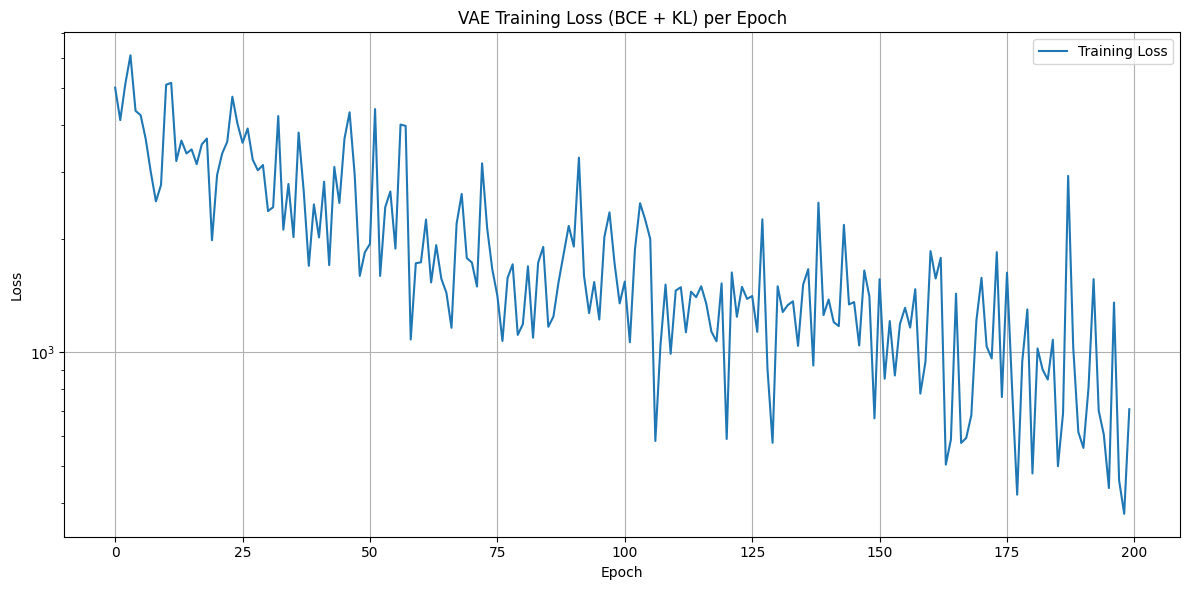

Final loss value: 707.460630


In [ ]:
# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss')
plt.legend()
plt.title('VAE Training Loss (BCE + KL) per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.yscale('log')  # Using log scale to better visualize the decreasing loss
plt.tight_layout()
plt.show()

# Print the final loss value
print(f"Final loss value: {losses[-1]:.6f}")

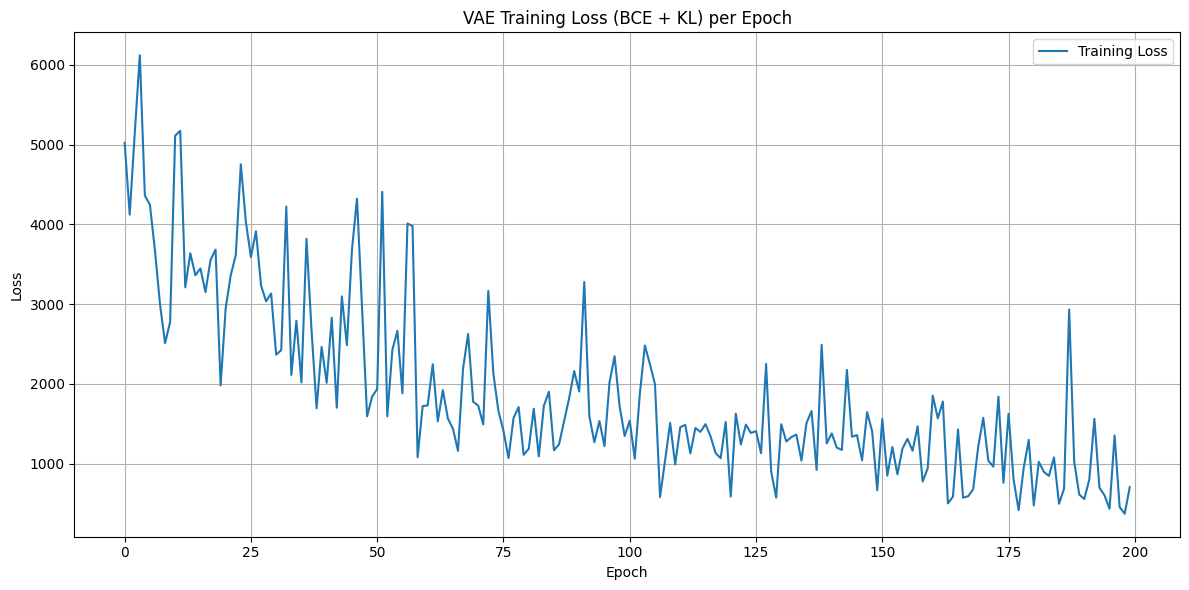

Final loss value: 707.460630


In [ ]:
# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss')
plt.legend()
plt.title('VAE Training Loss (BCE + KL) per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# plt.yscale('log')  # Using log scale to better visualize the decreasing loss
plt.tight_layout()
plt.show()

# Print the final loss value
print(f"Final loss value: {losses[-1]:.6f}")

# Random Run Selection and Inference
Now we'll select some random runs from the test model and use our trained VAE model to make predictions.

In [ ]:
# Set the number of random runs to select
num_runs = 5

# Get the available runs for the test model (excluding forced_response)
test_runs = [run for run in normalized_test_data[test_model].keys() if run != 'forced_response']
print(f"Available runs for {test_model}: {test_runs}")

# Randomly select runs
if len(test_runs) > num_runs:
    selected_runs = random.sample(test_runs, num_runs)
else:
    selected_runs = test_runs
    
print(f"Selected runs for visualization: {selected_runs}")

Available runs for GISS-E2-2-G: ['r1i1p1f1', 'r1i1p3f1', 'r2i1p1f1', 'r2i1p3f1', 'r3i1p1f1', 'r3i1p3f1', 'r4i1p1f1', 'r4i1p3f1', 'r5i1p1f1', 'r5i1p3f1', 'r6i1p1f1']
Selected runs for visualization: ['r1i1p1f1', 'r1i1p3f1', 'r2i1p3f1', 'r5i1p1f1', 'r3i1p1f1']


In [ ]:
# Set VAE to evaluation mode
vae_model.eval()

# Create a directory for saving animations if it doesn't exist
animation_dir = os.path.join('outputs_vae_test', 'animations', 'vae')
os.makedirs(animation_dir, exist_ok=True)
print(f"Animations will be saved to: {animation_dir}")

# Get ground truth for the test model
ground_truth = normalized_test_data[test_model]['forced_response']

# Store predictions for visualization
predictions = {}
mse_values = {}

# Generate predictions for each selected run
for run in selected_runs:
    # Get the run data
    run_data = normalized_test_data[test_model][run] # Shape 165 x 6523
    
    # Convert to torch tensor
    input_tensor = torch.tensor(run_data, dtype=torch.float32).unsqueeze(0).contiguous().view(1,-1).to(device) # Shape 1076295 = input_dim
    print(input_tensor.shape)
    
    # Make prediction with the VAE
    with torch.no_grad():
        # Forward pass through the VAE
        reconstructed, mu, log_var = vae_model(input_tensor)
        prediction = reconstructed.reshape(165, 6523).cpu().numpy()
    
    # Store prediction
    predictions[run] = prediction  # Reshape to original dimensions
    
    # Calculate MSE
    mse = np.mean((prediction - ground_truth) ** 2)
    mse_values[run] = mse
    print(f"MSE for {test_model} - {run}: {mse:.4f}")

print(f"\nAverage MSE across all selected runs: {np.mean(list(mse_values.values())):.4f}")

Animations will be saved to: outputs_vae_test/animations/vae
torch.Size([1, 1076295])
MSE for GISS-E2-2-G - r1i1p1f1: 0.0325
torch.Size([1, 1076295])
MSE for GISS-E2-2-G - r1i1p3f1: 0.0276
torch.Size([1, 1076295])
MSE for GISS-E2-2-G - r2i1p3f1: 0.0298
torch.Size([1, 1076295])
MSE for GISS-E2-2-G - r5i1p1f1: 0.0337
torch.Size([1, 1076295])
MSE for GISS-E2-2-G - r3i1p1f1: 0.0361

Average MSE across all selected runs: 0.0320


In [ ]:
# Find the color limits for consistent visualization
all_data = []

# Add ground truth data
ground_truth_with_nans = readd_nans_to_grid(ground_truth, nan_mask, predictions=True)
all_data.append(ground_truth_with_nans)

# Add input data and predictions
for run in selected_runs:
    # Input data
    input_data = readd_nans_to_grid(normalized_test_data[test_model][run], nan_mask, predictions=True)
    all_data.append(input_data)
    
    # Prediction
    prediction_with_nans = readd_nans_to_grid(predictions[run], nan_mask, predictions=True)
    all_data.append(prediction_with_nans)

# Find the minimum and maximum values across all data
all_data_concatenated = np.concatenate([data.flatten() for data in all_data])
all_data_concatenated = all_data_concatenated[~np.isnan(all_data_concatenated)]
vmin, vmax = np.nanpercentile(all_data_concatenated, [2, 98])

print(f"Color limits for visualization: [{vmin:.2f}, {vmax:.2f}]")

Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Color limits for visualization: [-4.48, 0.56]


In [ ]:
# Generate animations
for run in selected_runs:
    print(f"\nGenerating animations for {test_model} - {run}...")
    
    # Reshape data for animation
    input_data = readd_nans_to_grid(normalized_test_data[test_model][run], nan_mask, predictions=True)
    input_data = input_data.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
    
    prediction_data = readd_nans_to_grid(predictions[run], nan_mask, predictions=True)
    prediction_data = prediction_data.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
    
    ground_truth_data = readd_nans_to_grid(ground_truth, nan_mask, predictions=True)
    ground_truth_data = ground_truth_data.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
    
    # Create animations
    save_path = animation_dir
    
    # Input animation
    input_animation = animate_data(
        input_data,
        title=f'Input: {test_model} - {run} (MSE: {mse_values[run]:.2f})',
        interval=200,
        cmap='viridis',
        color_limits=(vmin, vmax)
    )
    display(HTML(input_animation.to_html5_video()))
    input_animation.save(f"{save_path}/vae_input_{test_model}_{run}.mp4", writer='ffmpeg', fps=15)
    
    # Prediction animation
    pred_animation = animate_data(
        prediction_data,
        title=f'VAE Prediction: {test_model} - {run} (MSE: {mse_values[run]:.2f})',
        interval=200,
        cmap='viridis',
        color_limits=(vmin, vmax)
    )
    display(HTML(pred_animation.to_html5_video()))
    pred_animation.save(f"{save_path}/vae_prediction_{test_model}_{run}.mp4", writer='ffmpeg', fps=15)
    
    # Ground truth animation (only once)
    if run == selected_runs[0]:
        gt_animation = animate_data(
            ground_truth_data,
            title=f'Ground Truth: {test_model}',
            interval=200,
            cmap='viridis',
            color_limits=(vmin, vmax)
        )
        display(HTML(gt_animation.to_html5_video()))
        gt_animation.save(f"{save_path}/vae_ground_truth_{test_model}.mp4", writer='ffmpeg', fps=15)
    
print(f"\nAll animations have been saved to {save_path}")


Generating animations for GISS-E2-2-G - r1i1p1f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...



Generating animations for GISS-E2-2-G - r1i1p3f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...



Generating animations for GISS-E2-2-G - r2i1p3f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...



Generating animations for GISS-E2-2-G - r5i1p1f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...



Generating animations for GISS-E2-2-G - r3i1p1f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...



All animations have been saved to outputs_vae_test/animations/vae


# Performance Analysis
Let's analyze the performance of our VAE model by comparing the MSE across different runs.

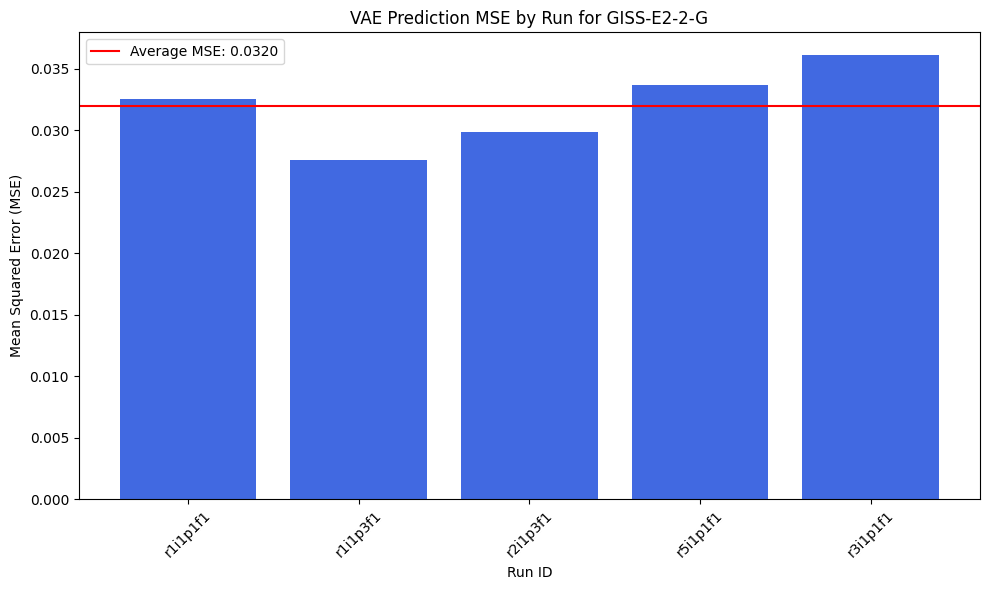

In [ ]:
# Plot MSE comparison
plt.figure(figsize=(10, 6))
runs = list(mse_values.keys())
mse_vals = list(mse_values.values())

plt.bar(runs, mse_vals, color='royalblue')
plt.axhline(y=np.mean(mse_vals), color='r', linestyle='-', label=f'Average MSE: {np.mean(mse_vals):.4f}')
plt.title(f'VAE Prediction MSE by Run for {test_model}')
plt.xlabel('Run ID')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{animation_dir}/vae_mse_comparison_{test_model}.png", dpi=300, bbox_inches='tight')
plt.show()